In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [4]:
def load_data(folder):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            label = filename.split('.')[0]  # Filename is the label
            img_path = os.path.join(folder, filename)
            
            # Read Image (Grayscale)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0  # Normalize
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [5]:
image_folder = "samples"
X, y = load_data(image_folder)

In [6]:
X = X.reshape(-1, 50, 200, 1)

In [7]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

In [8]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(encoded_labels)), activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 198, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 33792)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [9]:
history = model.fit(X, encoded_labels, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
27/27 [==============================] - 8s 264ms/step - loss: 7.0150 - accuracy: 0.0000e+00 - val_loss: 6.9921 - val_accuracy: 0.0000e+00
Epoch 2/15
27/27 [==============================] - 6s 210ms/step - loss: 6.9730 - accuracy: 0.0012 - val_loss: 7.0110 - val_accuracy: 0.0000e+00
Epoch 3/15
27/27 [==============================] - 5s 198ms/step - loss: 6.9656 - accuracy: 0.0000e+00 - val_loss: 7.1011 - val_accuracy: 0.0000e+00
Epoch 4/15
27/27 [==============================] - 6s 205ms/step - loss: 6.9431 - accuracy: 0.0000e+00 - val_loss: 7.5382 - val_accuracy: 0.0000e+00
Epoch 5/15
27/27 [==============================] - 6s 216ms/step - loss: 6.9043 - accuracy: 0.0000e+00 - val_loss: 7.5245 - val_accuracy: 0.0000e+00
Epoch 6/15
27/27 [==============================] - 5s 195ms/step - loss: 6.8496 - accuracy: 0.0012 - val_loss: 7.9616 - val_accuracy: 0.0000e+00
Epoch 7/15
27/27 [==============================] - 6s 212ms/step - loss: 6.7914 - accuracy: 0.0023 - val_lo

In [10]:
model.save("captcha_model.h5")
print("Model Saved ✅")

Model Saved ✅


In [11]:
def predict(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found at:", image_path)
        return "Error"

    img = img / 255.0
    img = img.reshape(1, img.shape[0], img.shape[1], 1)

    prediction = model.predict(img)
    index = np.argmax(prediction)
    captcha_text = label_encoder.inverse_transform([index])

    return captcha_text[0]


In [12]:
test_image = "samples/2cg58.png"
print("Prediction:", predict(test_image))

1/1 [==============================] - 0s 212ms/step
Prediction: 2cg58


In [13]:
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved")

Label encoder saved


8/8 [==============================] - 0s 29ms/step


ValueError: The number of FixedLocator locations (368), usually from a call to set_ticks, does not match the number of labels (1070).

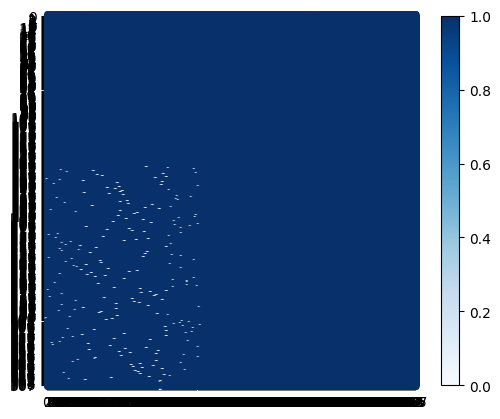

In [2]:
from tensorflow import keras
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder

# Function to load data
def load_data(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            label = filename.split('.')[0]  # Filename is the label
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load model and label encoder
model = keras.models.load_model("captcha_model.h5")
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load your data
image_folder = "samples"
X, y = load_data(image_folder)
X = X.reshape(-1, 50, 200, 1)
encoded_labels = label_encoder.transform(y)

# Split data for validation (using last 20% as validation)
split_idx = int(0.8 * len(X))
X_val = X[split_idx:]
y_val = encoded_labels[split_idx:]

# Predict with batch size 30
y_pred_probs = model.predict(X_val, batch_size=30)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()